# Planted SK model

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Latex
np.random.seed(14753)
%matplotlib inline

# Exercise 1

Write a function to sample an instance of $(\mathbf{s},\mathbf{J})$.


## Point c)

From points a) and b) of exercise 1 we know that the posterior distribution of $s$ is a Boltzmann distribution

$$ P(s | J ) \propto e^{\frac{\beta}{\sqrt{N}} \sum_{ij}J_{ij} s_i s_j}$$

To sample a particular realization we follow the generative model at hand: first we sample a "planted" realization of $s$ from the prior 

$$s_i \sim \frac{1}{2} \delta(s_i - 1) + \frac{1}{2} \delta(s_i + 1)$$

and then sample a realization of $J$ from the likelihood 

$$J_{ij} \sim N \left(\frac{s_i s_j}{\sqrt{N}}, \sigma^2 \right) $$

In [2]:
def sample_instance(size_x, var_noise):
    """Sample {x, J} from P(x, J)"""
    
    # Sample x from U({+1, -1}^N)
    x0 = np.random.choice([+1, -1], size_x)
    
    # Generate J = xx^T / sqrt(N) + noise
    W = np.outer(x0, x0) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_x, size_x)
    noise = np.tril(noise) + np.tril(noise).T  # make noise symmetric
    
    J = W + noise
    np.fill_diagonal(J, 0)  # set diagonal elements to zero

    return x0, J

In [3]:
var_noise = 0.1
x0, J = sample_instance(size_x=5000, var_noise=var_noise)
print(x0, end='\n\n')
print(J)

[ 1  1 -1 ...  1 -1  1]

[[ 0.         -0.01402384  0.37446827 ... -0.57908625  0.24606049
  -0.09781867]
 [-0.01402384  0.         -0.25387192 ...  0.21896855 -0.48342456
   0.47098177]
 [ 0.37446827 -0.25387192  0.         ...  0.0005851  -0.05790875
   0.28537195]
 ...
 [-0.57908625  0.21896855  0.0005851  ...  0.          0.40979618
   0.48746639]
 [ 0.24606049 -0.48342456 -0.05790875 ...  0.40979618  0.
  -0.13028925]
 [-0.09781867  0.47098177  0.28537195 ...  0.48746639 -0.13028925
   0.        ]]


## Points d) e) f)

* d) Write a function that implements the TAP equation to approximate the mean $\hat{\mathbf{s}}$ of $P(\mathbf{s}|\mathbf{J})$.   
his is an iteration that, if it converges, gives a very good approximation for $\hat{\mathbf{s}}$ as $N\rightarrow \infty$.   
For numerical reasons implement the fixed point iterations as follows:
\begin{align*}
m_i^{(t+1)} &= \tanh \left(  \frac{1}{\sigma^2 \sqrt{N}} \sum_j J_{ij} \, m_j^{(t)}  \right)   && \mbox{Mean Field}   	\\
m_i^{(t+1)} &= \tanh \left(  
	\frac{1}{\sigma^2 \sqrt{N}} \sum_j J_{ij} \, m_j^{(t)}  - 
	m_i^{(t-1)} \frac{1}{N \sigma^4} \sum_j J^{2}_{ij}\, (1 - (m_j^{(t)})^2)   \right)      
	&& \mbox{TAP}   	\\
\end{align*}  

* e) Run some experiments ($N_{real} \in [10,100]$ re-samplings of $J, s$ at your choice) for $N=10,100,1000,5000$ and fixed $\sigma^{2}=0.1$ and check that the overlap  with ground-truth improves with the iterations.  

The overlap is defined as: $overlap(\mathbf{m},\mathbf{s}_{0}) := | \frac{\mathbf{m}\cdot \mathbf{s}_{0}}{N}|$.  

* f) 
    * i) Run sum experiments ($N_{real} \in [10,100]$ re-samplings of $J, s$ at your choice) for $N=10,100,1000,5000$ and varying $\sigma^{2} \in [0.1,2]$. 
    * ii) Repeat the same experiments but using the MF approximation instead.  
    * iii) Plot the performance metrics values at convergence for TAP and MF as a function of the noise $\sigma^{2}$ for various $N$.  
Comment on what you observe.



In [4]:
def iterate_sc_equation(J, var_noise, s0=None, max_iter=None, tol=1e-7, verbose=True, approximation='MF'):
    """Iterate MF or TAP self-consistency equation"""
    
    # Some pre-processing
    size_x = J.shape[0]
    max_iter = max_iter or 100 * size_x
    
    # Initialize variables
    B = np.zeros(size_x)
    m = np.random.rand(size_x)
    m_old = np.zeros(size_x)
    
    for t in range(max_iter):
        # Perform iteration
        if approximation == 'TAP':
            B = (J.dot(m) / np.sqrt(size_x) - (1./ (var_noise*size_x))*m_old * (J**2).dot(1 - m ** 2)) / var_noise
        elif approximation == 'MF':
            B = J.dot(m) / np.sqrt(size_x) / var_noise
        m_old = np.copy(m)
        m = np.tanh(B)
         
        # Compute metrics
        diff = np.mean(np.abs(m - m_old))
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g" % (t, diff))
        
        # Check for convergence
        if diff < tol:
            break
            
    return m

Example of call of iterate_tap

In [5]:
iterate_sc_equation(J, var_noise, max_iter=30, approximation='TAP')

t = 0, diff = 0.812344
t = 1, diff = 0.891782
t = 2, diff = 0.930618
t = 3, diff = 0.926825
t = 4, diff = 0.758826
t = 5, diff = 0.295786
t = 6, diff = 0.0200339
t = 7, diff = 0.00149867
t = 8, diff = 0.00021351
t = 9, diff = 4.22822e-05
t = 10, diff = 8.0304e-06
t = 11, diff = 1.27011e-06
t = 12, diff = 2.60082e-07
t = 13, diff = 4.23022e-08


array([ 0.99999987,  1.        , -1.        , ...,  1.        ,
       -1.        ,  0.99998863])

Run experiment for varying levels of noise

In [16]:
def run_experiment(noise_vars, size_x, verbose=False):
    """Compute overlap obtained by AMP using different noise variances"""
    overlaps_tap = np.zeros(len(noise_vars))
    overlaps_MF = np.zeros(len(noise_vars))
    
    # For each variance in noise_vars, sample new instance and run AMP
    for i, var in enumerate(noise_vars):
        x0, J = sample_instance(size_x=size_x, var_noise=var)
        
        m_tap = iterate_sc_equation(J, var, verbose=verbose, approximation='MF')
        m_MF = iterate_sc_equation(J, var, verbose=verbose, approximation='TAP')
        
        overlaps_tap[i] = np.abs(np.mean(m_tap * x0))
        overlaps_MF[i] = np.abs(np.mean(m_MF * x0))
        
    return overlaps_tap, overlaps_MF 

In [17]:
noise_vars = np.arange(0.1, 2.0, 0.25)
size_x = 100
n_real = 10

o_tap = []
o_MF = []

for rep in range(n_real):
    overlaps_tap, overlaps_MF  = run_experiment(noise_vars, size_x=size_x)
    o_tap.append(overlaps_tap)
    o_MF.append(overlaps_MF)
    print(rep,o_MF[-1].mean(),o_tap[-1].mean())
# turn lists of arrays into 2D arrays
o_tap, o_MF = tuple(
    map(
        np.array, 
        (o_tap, o_MF)
    )
)

0 0.2903989345181658 0.4153746579766111
1 0.2648482797520719 0.2884754029357579
2 0.28673903411283974 0.31750998597211194
3 0.2583375462585446 0.35279046284397575
4 0.31869526432905104 0.43138440802272227
5 0.3238345590148472 0.4394030981154677
6 0.28014694414066216 0.3750771364319073
7 0.23036608899728636 0.3908609647085785
8 0.33672268625883245 0.3866572772856889
9 0.31456835745424055 0.3502892755254492


In [18]:
### NOTE1: the last three points for MF have low, but not zero, standard deviation
### NOTE2: the absolute value is useful to avoid the possibility of optimal solutions
###        with inverse correlation with the sampled spins, i.e., ov = -1.

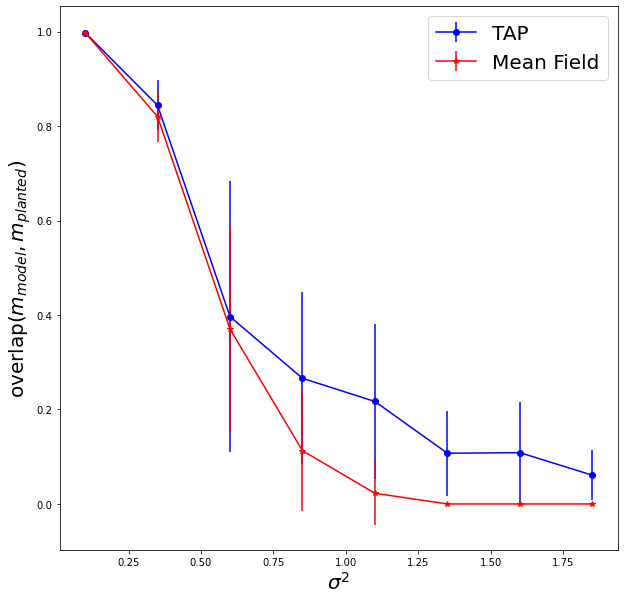

In [19]:
plt.figure(figsize=(10, 10))

plt.errorbar(noise_vars, o_tap.mean(axis=0), yerr=o_tap.std(axis=0), marker="o", c='b', label='TAP')
plt.errorbar(noise_vars, o_MF.mean(axis=0), yerr=o_MF.std(axis=0), marker="*", c='r', label='Mean Field')

plt.legend()
#plt.yscale("log")
plt.ylabel("overlap($m_{model},m_{planted}$)",fontsize=20)
plt.xlabel(r"$\sigma^2$",fontsize=20)
plt.legend(fontsize=20)

# plt.savefig('./figures/overlap_TAP_vs_MF_ex1.png')